In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


#warning
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)

# Import Data

In [64]:
data = pd.read_csv("med-insurance.csv")

In [3]:
data.head(10)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.90,0,yes,southwest,16884.92
1,18,male,33.80,1,no,southeast,1725.55
2,28,male,33.00,3,no,southeast,4449.46
3,33,male,22.70,0,no,northwest,21984.47
4,32,male,28.90,0,no,northwest,3866.86
5,31,female,25.70,0,no,southeast,3756.62
6,46,female,33.40,1,no,southeast,8240.59
7,37,female,27.70,3,no,northwest,7281.51
8,37,male,29.80,2,no,northeast,6406.41
9,60,female,25.80,0,no,northwest,28923.14


In [4]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [5]:
data["children"].value_counts()
# children feature is categorical

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [6]:
data["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [9]:
data.shape 

(1338, 7)

In [10]:
data.describe([.25,0.5,0.75,1]).T

,count,mean,std,min,25%,50%,75%,100%,max
age,1338.00,39.21,14.05,18.00,27.00,39.00,51.00,64.00,64.00
bmi,1338.00,30.67,6.10,16.00,26.30,30.40,34.70,53.10,53.10
children,1338.00,1.09,1.21,0.00,0.00,1.00,2.00,5.00,5.00
expenses,1338.00,13270.42,12110.01,1121.87,4740.29,9382.03,16639.92,63770.43,63770.43


# Missing Value

In [11]:
import missingno as msno
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

Text(0.5, 1.0, 'Missing Values Map')

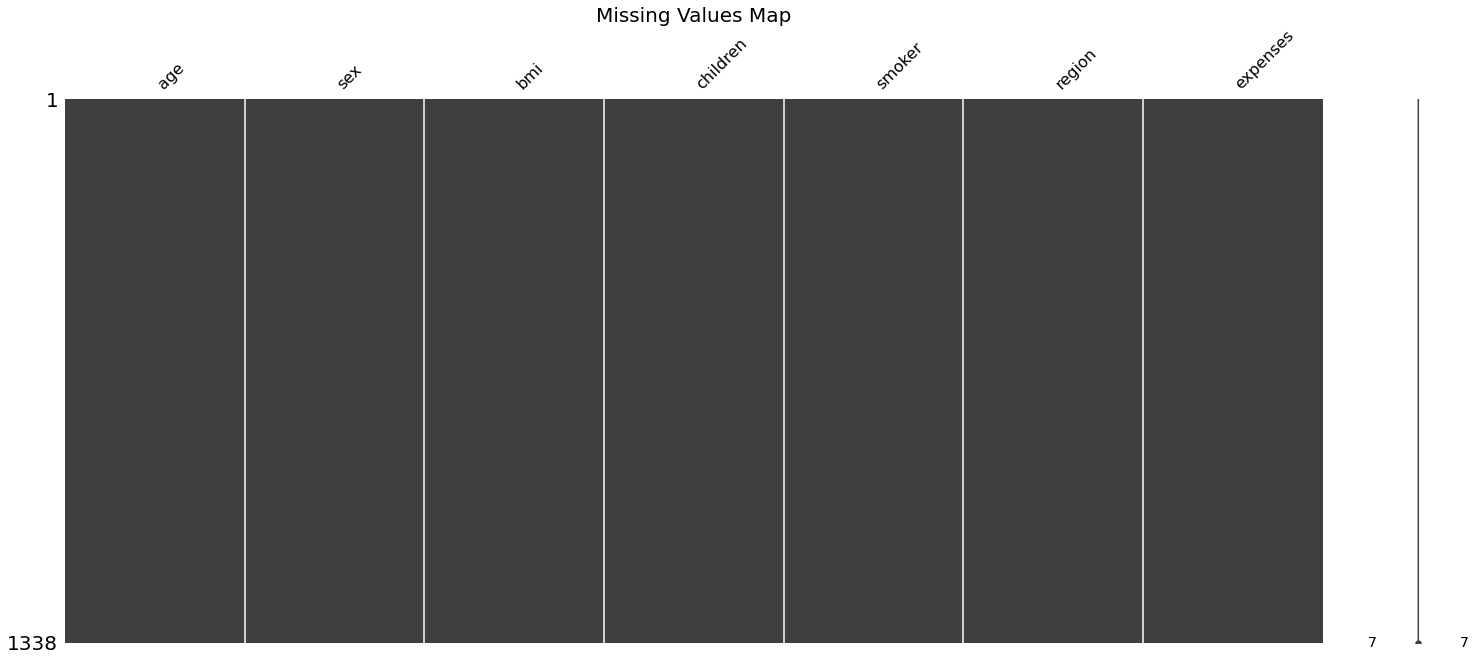

In [12]:
# Missing Value Map
msno.matrix(data).set_title("Missing Values Map",fontsize=20)

<AxesSubplot:xlabel='region'>

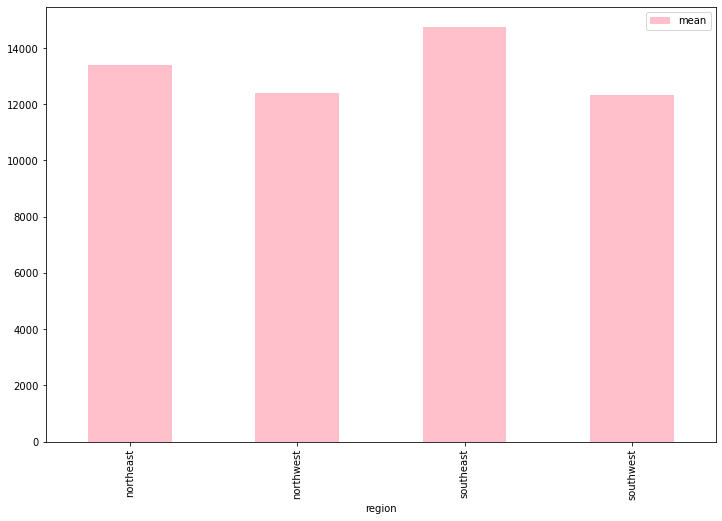

In [13]:
grouped = data.groupby("region")["expenses"].agg(["mean"])
grouped.plot(kind = "bar", figsize=(12,8), color="pink")

<AxesSubplot:xlabel='sex'>

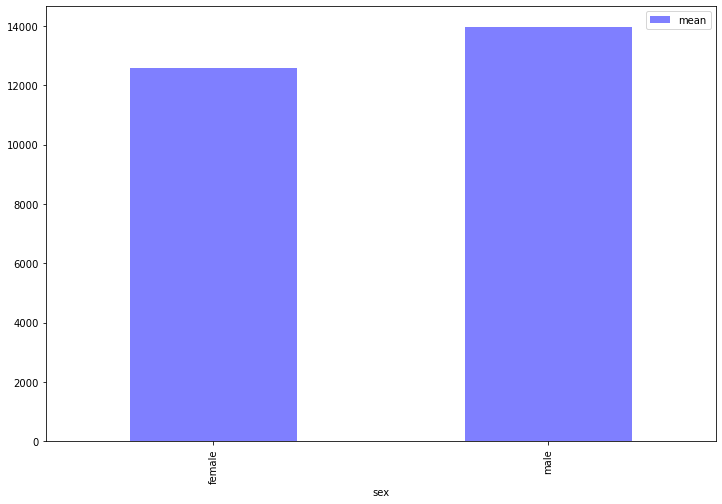

In [14]:
grouped_2 = data.groupby("sex")["expenses"].agg(["mean"])
grouped_2.plot(kind="bar", figsize=(12,8), color="blue",alpha=0.5)

<AxesSubplot:xlabel='smoker'>

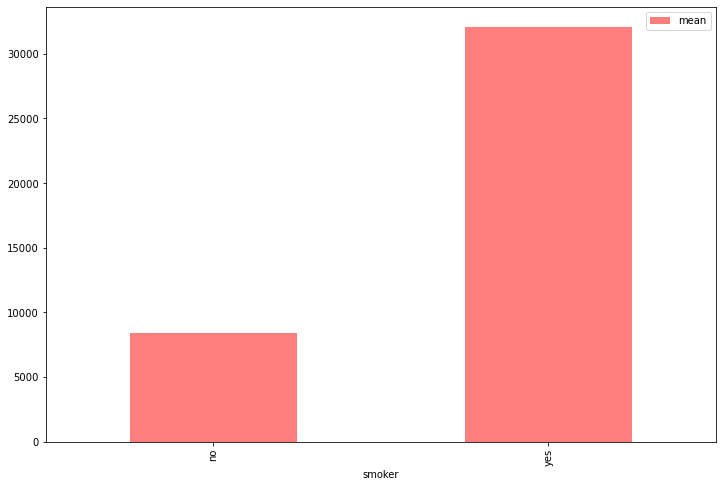

In [15]:
grouped_3 = data.groupby("smoker")["expenses"].agg(["mean"])
grouped_3.plot(kind="bar", figsize=(12,8), color="red",alpha=0.5)

In [65]:
data_2 = data.copy()
data_2["children"] = data_2["children"].replace(0,"0 Çocuk")
data_2["children"] = data_2["children"].replace(1,"1 Çocuk")
data_2["children"] = data_2["children"].replace(2,"2 Çocuk")
data_2["children"] = data_2["children"].replace(3,"3 Çocuk")
data_2["children"] = data_2["children"].replace(4,"4 Çocuk")
data_2["children"] = data_2["children"].replace(5,"5 Çocuk")

In [21]:
data_2["children"].value_counts() , data_2.dtypes

(0 Çocuk    574
 1 Çocuk    324
 2 Çocuk    240
 3 Çocuk    157
 4 Çocuk     25
 5 Çocuk     18
 Name: children, dtype: int64,
 age           int64
 sex          object
 bmi         float64
 children     object
 smoker       object
 region       object
 expenses    float64
 dtype: object)

<AxesSubplot:xlabel='children'>

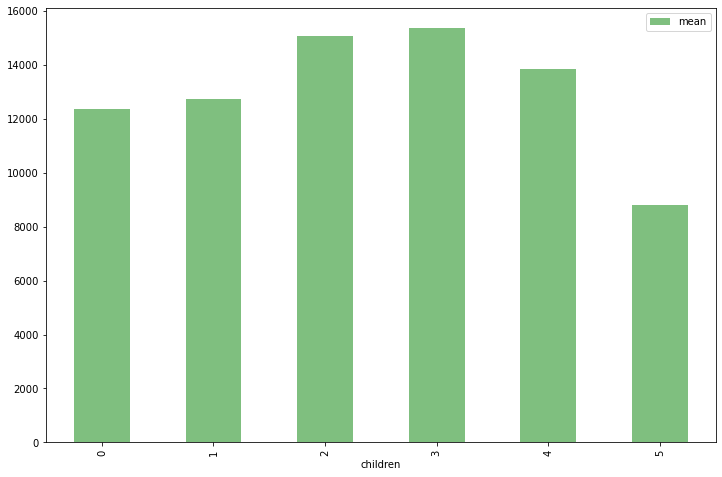

In [22]:
grouped_4 = data.groupby("children")["expenses"].agg(["mean"])
grouped_4.plot(kind="bar", figsize=(12,8), color="green", alpha=0.5)

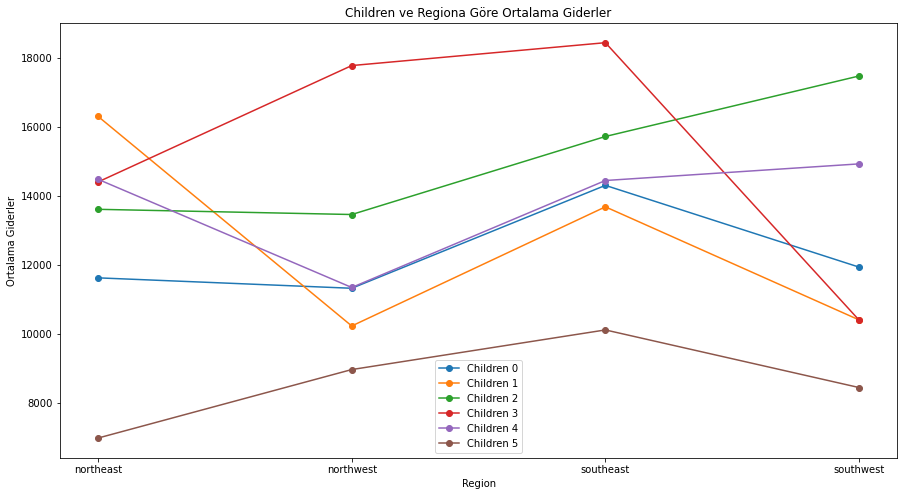

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
grouped_data = data.groupby(['children', 'region'])['expenses'].mean().reset_index()
plt.figure(figsize=(15, 8))
for child in grouped_data['children'].unique():
    region_data = grouped_data[grouped_data['children'] == child]
    plt.plot(region_data['region'], region_data['expenses'], marker='o', label=f'Children {child}')
plt.xlabel('Region')
plt.ylabel('Ortalama Giderler')
plt.title('Children ve Regiona Göre Ortalama Giderler')
plt.legend()
plt.show()

In [24]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["category","object","bool"]]
    num_cat_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int64","int32","float64","float32"]
                    and dataframe[col].nunique() < cat_th]
    cat_cols += num_cat_cols

    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtype in ["category","object"]
                   and dataframe[col].nunique() > car_th]

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtype in ["int64","float64"]
                and dataframe[col].nunique() > cat_th]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_cat_cols: {len(num_cat_cols)}")

    return cat_cols,num_cols,cat_but_car


cat_cols,num_cols,cat_but_car = grab_col_names(data)

Observations: 1338
Variables: 7
cat_cols: 4
num_cols: 3
cat_but_car: 0
num_cat_cols: 1


        sex  Ratio
male    676  50.52
female  662  49.48
###################################


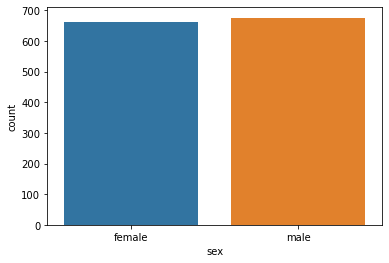

           region  Ratio
southeast     364  27.20
southwest     325  24.29
northwest     325  24.29
northeast     324  24.22
###################################


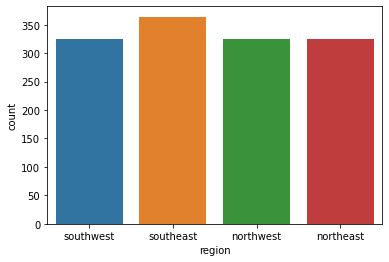

   children  Ratio
0       574  42.90
1       324  24.22
2       240  17.94
3       157  11.73
4        25   1.87
5        18   1.35
###################################


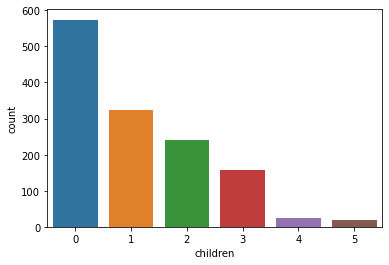

     smoker  Ratio
no     1064  79.52
yes     274  20.48
###################################


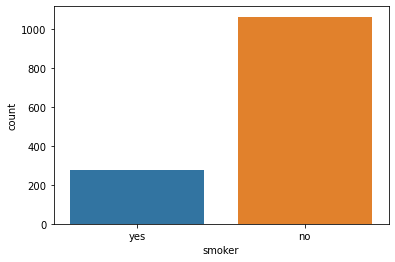

In [18]:
def cat_summary(dataframe, col_name,plot=False):
    if dataframe[col_name].dtype == 'bool':
        dataframe[col_name] = dataframe[col_name].astype(int)

    print(pd.DataFrame({col_name:data[col_name].value_counts(),
                        "Ratio":100*data[col_name].value_counts()/len(dataframe)}))
    print("###################################")

    if plot:
        sns.countplot(x=dataframe[col_name],data=dataframe)
        plt.show(block=True)

cat_summary(data,"sex",plot=True)
cat_summary(data,"region",plot=True)
cat_summary(data,"children",plot=True)
cat_summary(data,"smoker",plot=True)

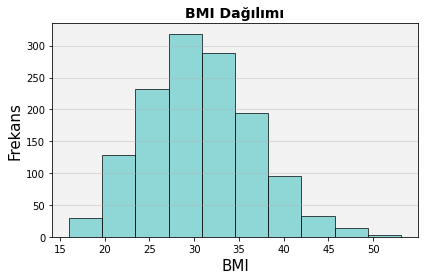

In [25]:
plt.hist(data['bmi'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.xlabel('BMI', fontsize=15)
plt.ylabel('Frekans', fontsize=15)
plt.title('BMI Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

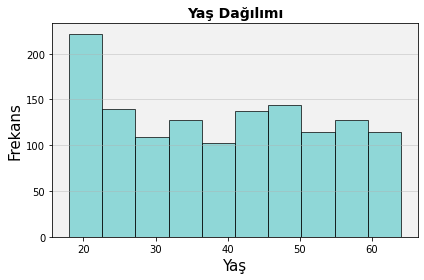

In [29]:
plt.hist(data['age'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.xlabel('Yaş', fontsize=15)
plt.ylabel('Frekans', fontsize=15)
plt.title('Yaş Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

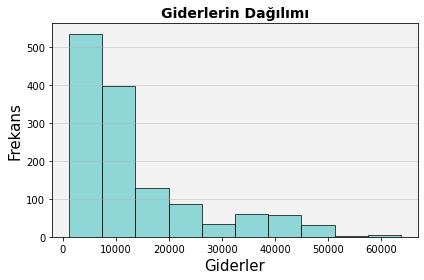

In [28]:
plt.hist(data['expenses'], bins=10, edgecolor='black', color='#66CCCC', alpha=0.7)
plt.xlabel('Giderler', fontsize=15)
plt.ylabel('Frekans', fontsize=15)
plt.title('Giderlerin Dağılımı', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_facecolor('#F2F2F2')
plt.tight_layout()
plt.show()

# Corr Matrix

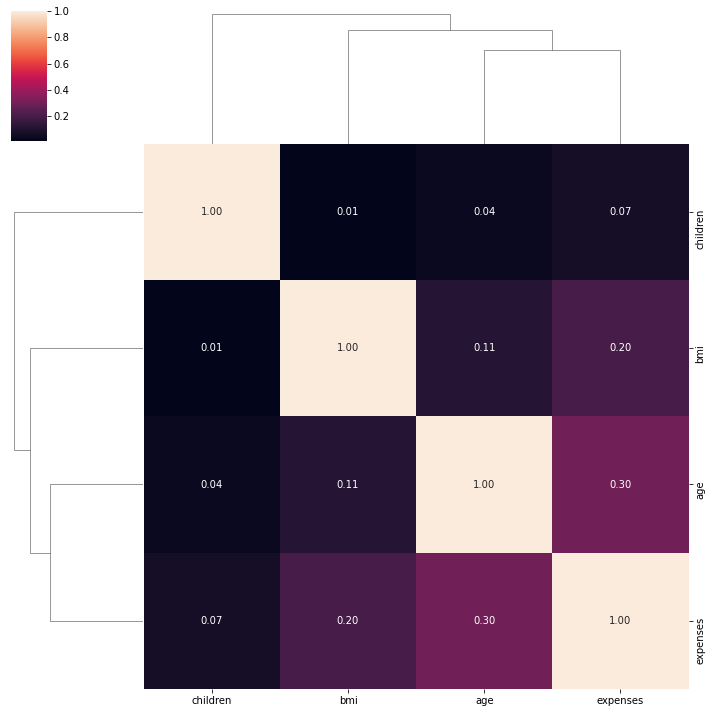

In [30]:
corr_matrix = data.corr()
sns.clustermap(corr_matrix, annot=True, fmt = ".2f")
plt.show()

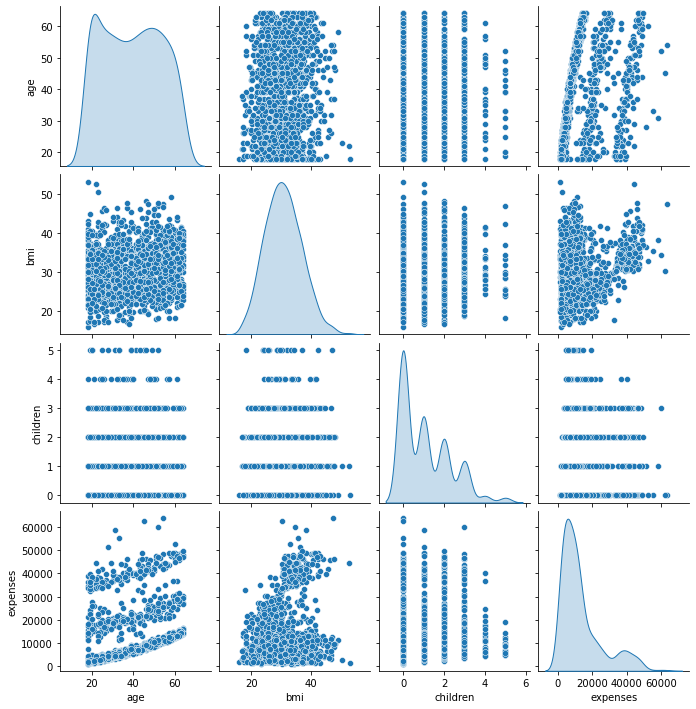

In [31]:
sns.pairplot(data, diag_kind="kde")
plt.show()

# Outlier Detection

In [32]:
# Threshold setting function
def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    iqr = quartile3 - quartile1
    low_limit = quartile1 - 1.5*iqr
    up_limit = quartile3 + 1.5*iqr
    return low_limit,up_limit

In [33]:
# Is there an outlier or not?
def check_outlier(dataframe,col_name):
    low,up = outlier_thresholds(dataframe,col_name)
    if dataframe[(dataframe[col_name] < low) | (dataframe[col_name]>up)].any(axis=None):
        return True
    else:
        return False

In [34]:
check_outlier(data,"bmi")

True

In [35]:
check_outlier(data,"age")

False

In [36]:
check_outlier(data,"expenses")

True

In [37]:
# Which observations outlier ?
def grab_outliers(dataframe,col,index=False):
    low,up = outlier_thresholds(dataframe,col)
    if not dataframe[(dataframe[col] < low) | (dataframe[col] > up)].any(axis=None):
        print("There is no outlier")
        return 0
    if dataframe[(dataframe[col] < low) | (dataframe[col] > up)].shape[0] > 10:
        print(dataframe[(dataframe[col] < low) | (dataframe[col] > up)].head())
    else:
        print(dataframe[(dataframe[col] < low) | (dataframe[col] > up)])
    if index:
        return dataframe[(dataframe[col] < low) | (dataframe[col] > up)].index

In [38]:
grab_outliers(data,"bmi")

      age     sex   bmi  children smoker     region  expenses
116    58    male 49.10         0     no  southeast  11381.33
286    46  female 48.10         2     no  northeast   9432.93
401    47    male 47.50         1     no  southeast   8083.92
543    54  female 47.40         0    yes  southeast  63770.43
847    23    male 50.40         1     no  southeast   2438.06
860    37  female 47.60         2    yes  southwest  46113.51
1047   22    male 52.60         1    yes  southeast  44501.40
1088   52    male 47.70         1     no  southeast   9748.91
1317   18    male 53.10         0     no  southeast   1163.46


In [39]:
grab_outliers(data,"expenses")

    age     sex   bmi  children smoker     region  expenses
14   27    male 42.10         0    yes  southeast  39611.76
19   30    male 35.30         0    yes  southwest  36837.47
23   34  female 31.90         1    yes  northeast  37701.88
29   31    male 36.30         2    yes  southwest  38711.00
30   22    male 35.60         0    yes  southwest  35585.58


# Normality Test

In [44]:
df = pd.DataFrame(data)

# Çoklu normallik testi
for column in num_cols:
    if column != 'Sex':
        statistic, p_value = shapiro(df[column])
        print(f'{column}:')
        print(f'Statistic: {statistic:.4f}')
        print(f'p-value: {p_value:.4f}')
        if p_value > 0.05:
            print('Dağılım normaldir.')
        else:
            print('Dağılım normal değildir.')
        print('-------------------------')

age:
Statistic: 0.9447
p-value: 0.0000
Dağılım normal değildir.
-------------------------
bmi:
Statistic: 0.9938
p-value: 0.0000
Dağılım normal değildir.
-------------------------
expenses:
Statistic: 0.8147
p-value: 0.0000
Dağılım normal değildir.
-------------------------


# Feature Engineering

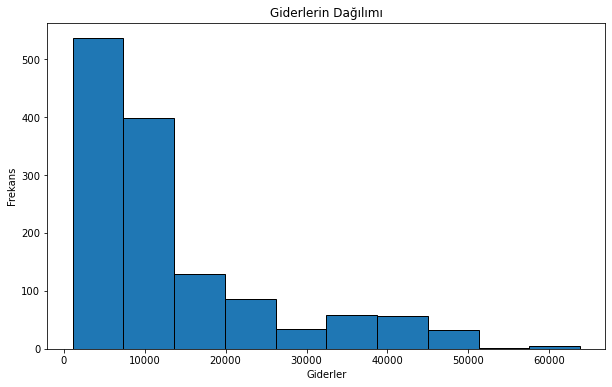

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(data['expenses'], bins=10, edgecolor='black')
plt.xlabel('Giderler')
plt.ylabel('Frekans')
plt.title('Giderlerin Dağılımı')
plt.show()

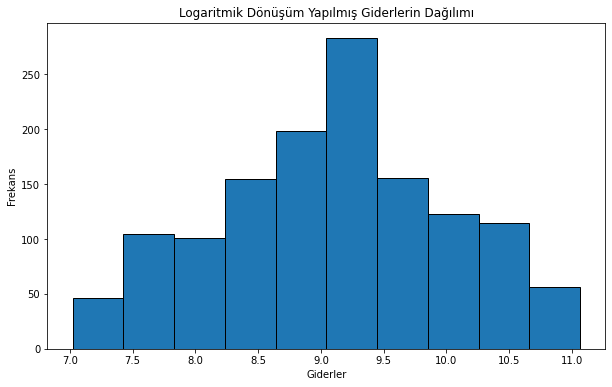

In [66]:
# MPG -> log transformation
from scipy import stats
from scipy.stats import norm,skew

data["expenses"] = np.log1p(data["expenses"])
plt.figure(figsize=(10, 6))
plt.hist(data['expenses'], bins=10, edgecolor='black')
plt.xlabel('Giderler')
plt.ylabel('Frekans')
plt.title('Logaritmik Dönüşüm Yapılmış Giderlerin Dağılımı')
plt.show()

In [67]:
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.90,0,yes,southwest,9.73
1,18,male,33.80,1,no,southeast,7.45
2,28,male,33.00,3,no,southeast,8.40
3,33,male,22.70,0,no,northwest,10.00
4,32,male,28.90,0,no,northwest,8.26


In [68]:
data_2["expenses"] = np.log1p(data_2["expenses"])
data_2.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.90,0 Çocuk,yes,southwest,9.73
1,18,male,33.80,1 Çocuk,no,southeast,7.45
2,28,male,33.00,3 Çocuk,no,southeast,8.40
3,33,male,22.70,0 Çocuk,no,northwest,10.00
4,32,male,28.90,0 Çocuk,no,northwest,8.26


In [69]:
df = pd.DataFrame(data_2)

# Çoklu normallik testi
for column in num_cols:
    if column != 'Sex':
        statistic, p_value = shapiro(df[column])
        print(f'{column}:')
        print(f'Statistic: {statistic:.4f}')
        print(f'p-value: {p_value:.4f}')
        if p_value > 0.05:
            print('Dağılım normaldir.')
        else:
            print('Dağılım normal değildir.')
        print('-------------------------')

age:
Statistic: 0.9447
p-value: 0.0000
Dağılım normal değildir.
-------------------------
bmi:
Statistic: 0.9938
p-value: 0.0000
Dağılım normal değildir.
-------------------------
expenses:
Statistic: 0.9832
p-value: 0.0000
Dağılım normal değildir.
-------------------------


## One Hot Encoding

In [70]:
data_2_encoding = pd.get_dummies(data_2)

In [71]:
data_2_encoding.head(10)

,age,bmi,expenses,sex_female,sex_male,children_0 Çocuk,children_1 Çocuk,children_2 Çocuk,children_3 Çocuk,children_4 Çocuk,children_5 Çocuk,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.90,9.73,1,0,1,0,0,0,0,0,0,1,0,0,0,1
1,18,33.80,7.45,0,1,0,1,0,0,0,0,1,0,0,0,1,0
2,28,33.00,8.40,0,1,0,0,0,1,0,0,1,0,0,0,1,0
3,33,22.70,10.00,0,1,1,0,0,0,0,0,1,0,0,1,0,0
4,32,28.90,8.26,0,1,1,0,0,0,0,0,1,0,0,1,0,0
5,31,25.70,8.23,1,0,1,0,0,0,0,0,1,0,0,0,1,0
6,46,33.40,9.02,1,0,0,1,0,0,0,0,1,0,0,0,1,0
7,37,27.70,8.89,1,0,0,0,0,1,0,0,1,0,0,1,0,0
8,37,29.80,8.77,0,1,0,0,1,0,0,0,1,0,1,0,0,0
9,60,25.80,10.27,1,0,1,0,0,0,0,0,1,0,0,1,0,0


# Label Encoder 

In [73]:
from sklearn.preprocessing import LabelEncoder
data_2_label_encoder = data_2
label_encoder = LabelEncoder()
data_2_label_encoder['sex'] = label_encoder.fit_transform(data_2_label_encoder['sex'])
data_2_label_encoder['smoker'] = label_encoder.fit_transform(data_2_label_encoder['smoker'])
data_2_label_encoder['children'] = label_encoder.fit_transform(data_2_label_encoder['children'])
data_2_label_encoder['region'] = label_encoder.fit_transform(data_2_label_encoder['region'])

In [79]:
data_2.head(10)

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.90,0,1,3,9.73
1,18,1,33.80,1,0,2,7.45
2,28,1,33.00,3,0,2,8.40
3,33,1,22.70,0,0,1,10.00
4,32,1,28.90,0,0,1,8.26
5,31,0,25.70,0,0,2,8.23
6,46,0,33.40,1,0,2,9.02
7,37,0,27.70,3,0,1,8.89
8,37,1,29.80,2,0,0,8.77
9,60,0,25.80,0,0,1,10.27


# Train , Test

In [75]:
x = data_2.drop(["expenses"],axis=1)
y = data_2["expenses"]
test_size=0.3
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=test_size, random_state = 35)

# Standart Scaler

In [76]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#  -  MODELS WITH LABEL ENCODER DATA -

In [77]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:57<00:00,  1.37s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.84,0.85,0.36,0.23
RandomForestRegressor,0.84,0.84,0.36,0.66
SVR,0.84,0.84,0.37,0.14
NuSVR,0.83,0.84,0.37,0.45
BaggingRegressor,0.83,0.84,0.37,0.09
HistGradientBoostingRegressor,0.83,0.83,0.38,2.15
LGBMRegressor,0.83,0.83,0.38,0.20
ExtraTreesRegressor,0.83,0.83,0.38,0.63
KNeighborsRegressor,0.82,0.82,0.39,0.04


#  -  MODELS WITH ONE HOT ENCODING DATA -

In [80]:
x = data_2_encoding.drop(["expenses"],axis=1)
y = data_2_encoding["expenses"]
test_size=0.3
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=test_size, random_state = 35)

In [81]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [82]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:32<00:00,  2.20s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RandomForestRegressor,0.84,0.84,0.36,0.72
GradientBoostingRegressor,0.83,0.84,0.37,0.19
HistGradientBoostingRegressor,0.83,0.84,0.37,2.22
LGBMRegressor,0.82,0.83,0.38,0.20
BaggingRegressor,0.82,0.83,0.38,0.17
SVR,0.81,0.82,0.39,0.12
ExtraTreesRegressor,0.81,0.81,0.40,0.61
NuSVR,0.80,0.81,0.40,0.41
XGBRegressor,0.78,0.79,0.43,0.20


#  Removing Outliers For Models

In [83]:
data_3 = data.copy()

In [84]:
# Removing outliers
def remove_outlier(dataframe,col):
    low,up = outlier_thresholds(dataframe,col)
    data_without_outliers = dataframe[~((data[col] < low) | (data[col]>up))]
    return data_without_outliers

data_3 = remove_outlier(data,"expenses")           # Remove MPG outliers
data_3 = remove_outlier(data,"bmi")   

In [85]:
data_3_encoding = pd.get_dummies(data_3)

In [86]:
x = data_3_encoding.drop(["expenses"],axis=1)
y = data_3_encoding["expenses"]
test_size=0.3
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=test_size, random_state = 35)

In [87]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [88]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:51<00:00,  1.24s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
SVR,0.86,0.86,0.33,0.19
NuSVR,0.86,0.86,0.33,0.23
GradientBoostingRegressor,0.85,0.85,0.35,0.40
HistGradientBoostingRegressor,0.80,0.81,0.40,1.56
LGBMRegressor,0.80,0.80,0.40,0.14
RandomForestRegressor,0.80,0.80,0.40,0.49
KNeighborsRegressor,0.79,0.80,0.41,0.03
BaggingRegressor,0.79,0.80,0.41,0.08
MLPRegressor,0.79,0.79,0.41,1.74


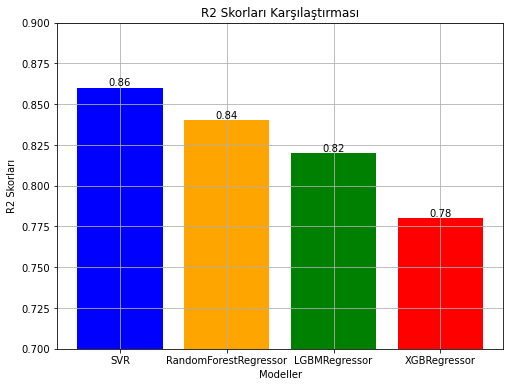

In [89]:
models = ['SVR', 'RandomForestRegressor', 'LGBMRegressor', 'XGBRegressor']
r2_scores = [0.86, 0.84, 0.82, 0.78]

plt.figure(figsize=(8, 6))
plt.bar(models, r2_scores, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Modeller')
plt.ylabel('R2 Skorları')
plt.title('R2 Skorları Karşılaştırması')

for i in range(len(models)):
    plt.text(i, r2_scores[i], f'{r2_scores[i]:.2f}', ha='center', va='bottom')

plt.ylim(0.7, 0.9)
plt.grid(True)
plt.show()

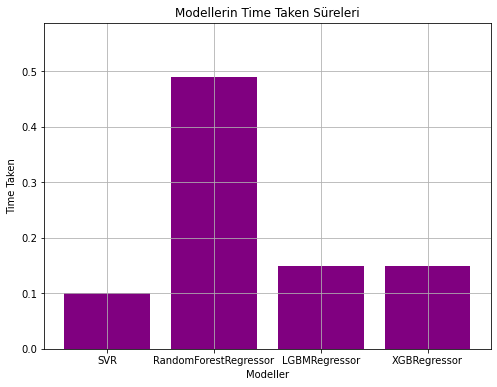

In [90]:
time_taken = [0.10, 0.49, 0.15, 0.15]

plt.figure(figsize=(8, 6))
plt.bar(models, time_taken, color='purple')
plt.xlabel('Modeller')
plt.ylabel('Time Taken')
plt.title('Modellerin Time Taken Süreleri')

plt.ylim(0, max(time_taken) * 1.2)
plt.grid(True)
plt.show()

## Models with southeast data

In [91]:

southeast_data = data.copy()
southeast_data = southeast_data[southeast_data['region'] == 'southeast'].copy()
# Removing outliers
def remove_outlier(dataframe,col):
    low,up = outlier_thresholds(dataframe,col)
    southeast_data_without_outliers = dataframe[~((southeast_data[col] < low) | (southeast_data[col]>up))]
    return southeast_data

southeast_data = remove_outlier(southeast_data,"expenses")           # Remove MPG outliers
southeast_data = remove_outlier(southeast_data,"bmi")   
southeast_data = pd.get_dummies(southeast_data)
x = southeast_data.drop(["expenses"],axis=1)
y = southeast_data["expenses"]
test_size=0.3
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=test_size, random_state = 35)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [75]:
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)
models

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 14.06it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
NuSVR,0.87,0.88,0.35,0.03
SVR,0.87,0.88,0.35,0.02
KNeighborsRegressor,0.84,0.85,0.39,0.02
HistGradientBoostingRegressor,0.84,0.85,0.39,0.36
LGBMRegressor,0.84,0.85,0.40,0.11
RandomForestRegressor,0.83,0.84,0.41,0.33
BaggingRegressor,0.83,0.84,0.41,0.04
GradientBoostingRegressor,0.82,0.83,0.42,0.06
DecisionTreeRegressor,0.80,0.81,0.44,0.02


# *Optimization of models (GridSearch)*


# SVR

In [92]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [93]:
svr = SVR()

# Optimizasyon için parametre aralığını belirleyin
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 0.5]
}

In [94]:
# GridSearchCV ile en iyi parametreleri bulun
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 0.5],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='neg_mean_squared_error')

In [95]:
# En iyi parametreleri ve en iyi skoru elde edin
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

In [96]:
# En iyi parametrelerle final SVR modelini oluşturun
final_svr = SVR(**best_params)
final_svr.fit(x_train, y_train)

SVR(C=1, kernel='poly')

In [97]:
# Test verileriyle tahmin yapın ve performansı değerlendirin
y_pred = final_svr.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = final_svr.score(x_test, y_test)

### SVR Modeli İçin Final Çıktısı

In [98]:
print("En iyi parametreler:", best_params)
print("En iyi skor (Negatif MSE):", best_score)
print("Test RMSE:", rmse)
print("Test R2 Skoru:", r2_score)

En iyi parametreler: {'C': 1, 'epsilon': 0.1, 'kernel': 'poly'}
En iyi skor (Negatif MSE): 0.16233580956528287
Test RMSE: 0.388158447280173
Test R2 Skoru: 0.8558586731827097


# Random Forest Regressor

In [99]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
rf = RandomForestRegressor()


In [101]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


In [102]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 5, 10],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [103]:
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

In [104]:
final_rf = RandomForestRegressor(**best_params)
final_rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=200)

In [105]:
y_pred = final_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = final_rf.score(x_test, y_test)

### Random Forest Regressor Modeli İçin Final Çıktısı

In [106]:
print("En iyi parametreler:", best_params)
print("En iyi skor (Negatif MSE):", best_score)
print("Test RMSE:", rmse)
print("Test R2 Skoru:", r2_score)

En iyi parametreler: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
En iyi skor (Negatif MSE): 0.18373138866961253
Test RMSE: 0.3740258808028933
Test R2 Skoru: 0.8661637559250475


# LGBM Regressor

In [107]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()

In [108]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'num_leaves': [31, 50, 100]
}

In [109]:
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 50, 100]},
             scoring='neg_mean_squared_error')

In [110]:
best_params = grid_search.best_params_
best_score = -grid_search.best_score_


In [111]:
final_lgbm = LGBMRegressor(**best_params)
final_lgbm.fit(x_train, y_train)

LGBMRegressor(learning_rate=0.05, max_depth=3)

In [112]:
y_pred = final_lgbm.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = final_lgbm.score(x_test, y_test)

### LGBM Regressor Modeli İçin Final Çıktısı

In [113]:
print("En iyi parametreler:", best_params)
print("En iyi skor (Negatif MSE):", best_score)
print("Test RMSE:", rmse)
print("Test R2 Skoru:", r2_score)

En iyi parametreler: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 31}
En iyi skor (Negatif MSE): 0.1824580948452434
Test RMSE: 0.3707296975085155
Test R2 Skoru: 0.8685122828868018


# XGB Regressor

In [114]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

In [115]:
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

In [116]:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=Non

In [117]:
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

In [118]:
final_xgb = XGBRegressor(**best_params)
final_xgb.fit(x_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [119]:
y_pred = final_xgb.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = final_xgb.score(x_test, y_test)

### XGB Regressor Modeli İçin Final Çıktısı

In [120]:
print("En iyi parametreler:", best_params)
print("En iyi skor (Negatif MSE):", best_score)
print("Test RMSE:", rmse)
print("Test R2 Skoru:", r2_score)

En iyi parametreler: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
En iyi skor (Negatif MSE): 0.1829432692073891
Test RMSE: 0.37956254803556705
Test R2 Skoru: 0.8621721002170191


# Neural Network

In [121]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor()

In [124]:
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

In [125]:
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(x_train, y_train)


GridSearchCV(cv=5, estimator=MLPRegressor(),
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(100,), (100, 50), (50, 50)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['adam', 'lbfgs']},
             scoring='neg_mean_squared_error')

In [126]:
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

In [127]:
final_mlp = MLPRegressor(**best_params)
final_mlp.fit(x_train, y_train)

MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(100, 50))

In [128]:
y_pred = final_mlp.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2_score = final_mlp.score(x_test, y_test)


### MLPRegressor (Neural Network) Modeli İçin Final Çıktısı

In [129]:
print("En iyi parametreler:", best_params)
print("En iyi skor (Negatif MSE):", best_score)
print("Test RMSE:", rmse)
print("Test R2 Skoru:", r2_score)

En iyi parametreler: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
En iyi skor (Negatif MSE): 0.20984818737245226
Test RMSE: 0.4297043389942582
Test R2 Skoru: 0.8233515180277016


## With tensorflow

In [149]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


In [150]:
model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

In [151]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [152]:
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

In [153]:
y_pred = model.predict(x_test)
r2_score = r2_score(y_test, y_pred)

4/4 [==============================] - 0s 3ms/step


In [154]:
print("Test R2 Skoru:", r2_score)

Test R2 Skoru: 0.8149654591017033


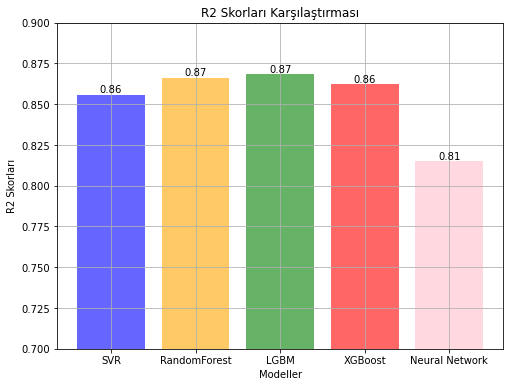

In [159]:
# Model isimleri ve R2 skorları
models = ['SVR', 'RandomForest', 'LGBM', 'XGBoost',"Neural Network"]
r2_scores = [0.8558, 0.8661, 0.8685, 0.8621, 0.815]

plt.figure(figsize=(8, 6))
plt.bar(models, r2_scores, color=['blue', 'orange', 'green', 'red',"pink"],alpha=0.6)
plt.xlabel('Modeller')
plt.ylabel('R2 Skorları')
plt.title('R2 Skorları Karşılaştırması')

for i in range(len(models)):
    plt.text(i, r2_scores[i], f'{r2_scores[i]:.2f}', ha='center', va='bottom')

plt.ylim(0.7, 0.9)
plt.grid(True)
plt.show()

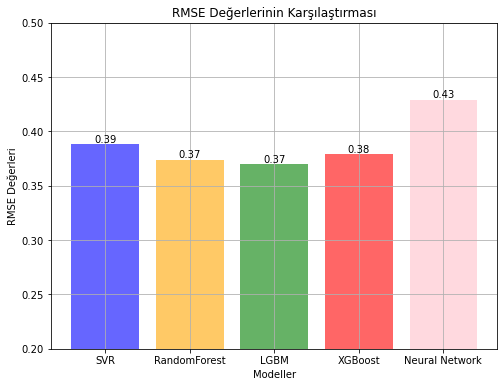

In [164]:
# Model isimleri ve RMSE Değerleri
models = ['SVR', 'RandomForest', 'LGBM', 'XGBoost',"Neural Network"]
rmse_scores = [0.388, 0.374, 0.370, 0.379, 0.429]

plt.figure(figsize=(8, 6))
plt.bar(models, rmse_scores, color=['blue', 'orange', 'green', 'red',"pink"],alpha=0.6)
plt.xlabel('Modeller')
plt.ylabel('RMSE Değerleri')
plt.title('RMSE Değerlerinin Karşılaştırması')

for i in range(len(models)):
    plt.text(i, rmse_scores[i], f'{rmse_scores[i]:.2f}', ha='center', va='bottom')

plt.ylim(0.2, 0.5)
plt.grid(True)
plt.show()

In [165]:
# Final Model = LGBM
# RMSE değeri en düşük modeldir.
# R2 Değeri en yüksek modeldir
# En kısa sürede kurulan ve optimize edilen modeldir.